In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
from seaborn import distplot, heatmap
from yellowbrick.features.radviz import radviz
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from dtaidistance.dtw import distance
from dtaidistance import dtw_ndim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
plt.rcParams['figure.figsize']=(12,8)

In [2]:
data = pd.read_csv('train_data/train_data.csv')
data

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,708,159,10.0040,0.2519,100.0,489.05,605.81,1508.72,1333.13,10.52,...,100.00,28.48,16.8884,NaN,NaN,NaN,NaN,NaN,NaN,4
160355,708,160,10.0074,0.2500,100.0,489.05,605.83,1509.90,1328.53,10.52,...,100.00,28.20,16.9498,NaN,NaN,NaN,NaN,NaN,NaN,3
160356,708,161,34.9982,0.8400,100.0,449.44,556.62,1374.56,1145.17,5.48,...,100.00,14.76,8.9228,NaN,NaN,NaN,NaN,NaN,NaN,2
160357,708,162,24.9993,0.6219,60.0,462.54,537.58,1274.92,1064.82,7.05,...,84.93,14.05,8.3890,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
class Clean :
    def __init__(self) :
        self.encoder = OrdinalEncoder()
        self.to_encode = ['op_setting_' + str(i) for i in range(1,4)]
        pass
    
    def cleaning(self, X) :
        clean_df= X.copy()
        
        #Drop failure steps
        clean_df = clean_df[clean_df.RUL != 0]
        
        #drop target column
        clean_df.drop(columns=['RUL'], inplace = True)
        
        #Drop sensors 22 to 27 with missing values
        clean_df = clean_df.drop(['sensor_' + str(i) for i in range(22,28)], axis = 1)
    
        #Settings columns correspond to categroical values, converting them to int
        clean_df[['op_setting_3', 'op_setting_1']] = clean_df[['op_setting_3', 'op_setting_1']].astype('int')
        clean_df['op_setting_2'] = (100 * clean_df['op_setting_2']).astype('int')
        
        #Add target feature 
        #clean_df['failure_in_100'] = (clean_df['RUL'] <= 100 ) *1
        
        return clean_df
    
    
    def fit_transform(self, X, y=None) :
        X_= X.copy()
        X_ = self.cleaning(X_)
        X_[self.to_encode] = self.encoder.fit_transform(X_[self.to_encode])
        
        return X_
    
    def transform(self, X, y=None) :
        X_= X.copy()
        X_ = self.cleaning(X_)
        X_[self.to_encode] = self.encoder.transform(X_[self.to_encode])
        return X_
    
    def fit(self, X, y=None) :
        self.encoder.fit(X_[self.to_encode])
        return self
    
class Scaler(StandardScaler) :
    def __init__(self) : 
        self.std = StandardScaler()
        self.to_std = ['sensor_' + str(i) for i in range(1,22)]
        
    def fit_transform(self, X, y=None) :
        X[self.to_std] = self.std.fit_transform(X[self.to_std])
        return X

    def transform(self, X, y=None) :
        X[self.to_std] = self.std.transform(X[self.to_std])
        return X
    def fit(self, X, y=None) :
        self.std.fit(X[self.to_std])
        return

class PCA_Reduction() :
    def __init__(self, n_components = 5) :
        self.n_components = n_components
        self.pca = PCA(n_components = self.n_components)
        self.to_reduce = ['op_setting_' + str(i) for i in range(1,4)] + ['sensor_' + str(i) for i in range(1,22)]
        pass
    
    def fit_transform(self, X, y=None) :
        X_ = X.copy()
        comp_features = ['pca_' + str(i) for i in range(1,self.n_components + 1)]
        X_[comp_features] = self.pca.fit_transform(X_[self.to_reduce])
        X_.drop(columns = self.to_reduce, inplace = True)
        return X_
    
    def transform(self, X, y=None) :
        X_ = X.copy()
        comp_features = ['pca_' + str(i) for i in range(1,self.n_components + 1)]
        X_[comp_features] = self.pca.transform(X_[self.to_reduce])
        X_.drop(columns = self.to_reduce, inplace = True)
        return X_
    def fit(self, X, y=None) :
        self.pca.fit(X_[self.to_reduce])
        return self
    
class TS_Extract() :
    """
    Transforms a dataframe into a numpy array of dimension (n_engines, n_steps, n_features) containing 
    the last n = n_steps time cycles for each engine.
    """
    def __init__(self, length = 50, stride = 20) :

        self.length = length
        self.stride = stride
        pass
    
    
    def extract_ts (self, X_arr) : 
        n_cycles = X_arr.shape[0]
        L = [ X_arr[i: i + self.length] for i in range(0, n_cycles - self.length+1 , self.stride)]
        return L

    def fit(self, X, y=None) :
        return self
    
    def fit_transform(self, X, y=None) :
        X_ = X.copy()

        X_.set_index(['engine_no'], inplace = True)
        
        L = []
        
        for engine in range(0, X_.index.get_level_values(0).max() +1) :
           
            engine_cycles = X_.loc[engine].to_numpy()
            
            L += self.extract_ts(engine_cycles)
        #L = np.array([X_.loc[i].iloc[-self.n_steps:].to_numpy() for i in range(0, X_.index.get_level_values(0).max() +1)])
        
        return np.array(L)
    
    def transform(self, X,y=None) :
        return self.fit_transform(X,y)


class Build_Target() :
    def __init__(self, length=1, stride=1) :
        self.length = length
        self.stride = stride
     
    def extract_targets (self, y_arr) : 
        n_cycles = y_arr.shape[0]
        
        L = [ y_arr[i + self.length-1] for i in range(0, n_cycles - self.length+1 , self.stride)]
        return L
    
    def fit_transform(self, X, y= None) :
        data_ = X.copy()
        data_ = data_[data_.RUL != 0]
        data_['failure_in_100'] = (data_.RUL <= 100 ) *1
        
        y = data_[['engine_no', 'time_in_cycles', 'failure_in_100']]
        
        y.set_index(['engine_no', 'time_in_cycles'], inplace=True)
        
        L = []
        for engine in range(0, y.index.get_level_values(0).max() +1) :
           
            engine_cycles = y.loc[engine].to_numpy()
            
            L += self.extract_targets(engine_cycles)
        return np.array(L)
    
    def transform(self, X, y=None) :
        return self.fit_transform(X,y)
    
    def fit(X, y=None) :
        return self
        


In [7]:
length = 100
stride = 10
n_components = 10

X_pipe = Pipeline(steps = [
    ('cleaning', Clean()),
    ('scaling', Scaler()),
    ('reduction', PCA_Reduction(n_components = n_components)),
    ('time_series_extraction', TS_Extract(length, stride))
])

y_pipe = Pipeline(steps = [
    ('target_extraction', Build_Target(length, stride))
])

y = y_pipe.fit_transform(data)
X = X_pipe.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)

In [8]:
class Build_Dataset :
    def __init__(self, batch_size = 100, shuffle = True) :
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        
    def create_dataset(self, X , y) :
        inputs = tf.data.Dataset.from_tensor_slices(X)
        outputs = tf.data.Dataset.from_tensor_slices(y.astype('float'))
        
        dataset = tf.data.Dataset.zip((inputs,outputs))
        if self.shuffle : 
            dataset = dataset.shuffle(X.shape[0])
        
        dataset = dataset.batch(self.batch_size, drop_remainder = True)
        
        return dataset
    
ds = Build_Dataset(batch_size = 100, shuffle = False)
train_dataset = ds.create_dataset(X_train, y_train)
test_dataset = ds.create_dataset(X_test, y_test)

In [9]:
class F1_Score(tf.keras.metrics.Metric) :
    def __init__(self, name = 'f1_score', thresholds = 0.5) :
        super().__init__(name = name)
        self.thresholds = thresholds
        self.precision = tf.keras.metrics.Precision(thresholds)
        self.recall = tf.keras.metrics.Recall(thresholds)
        self.f1_score = self.add_weight(name='f1', initializer='zeros')
        pass
    
    def update_state(self, y_true, y_pred, sample_weight = None) :
        r = self.recall(y_true, y_pred)
        p = self.precision(y_true, y_pred)
        f1 = 2 * p * r / (p + r + 1e-6)
        self.f1_score.assign(f1)
        return
    
    def result(self) :
        return self.f1_score
    
    def reset_states(self) :
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0)

# MLP

In [468]:
inputs = tf.keras.Input(shape=(length,X_train.shape[-1]))

flattened_inputs = tf.keras.layers.Flatten()(inputs)

hidden1 = tf.keras.layers.Dense(100, activation="relu")(flattened_inputs)

hidden2 = tf.keras.layers.Dense(100, activation="relu")(hidden1)


hidden3 = tf.keras.layers.Dense(100, activation="relu")(hidden2)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(hidden3)


linear = tf.keras.Model(inputs, outputs)

linear.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
linear.summary()

Model: "model_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_144 (InputLayer)       [(None, 100, 6)]          0         
_________________________________________________________________
flatten_63 (Flatten)         (None, 600)               0         
_________________________________________________________________
dense_284 (Dense)            (None, 100)               60100     
_________________________________________________________________
dense_285 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_286 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_287 (Dense)            (None, 1)                 101       
Total params: 80,401
Trainable params: 80,401
Non-trainable params: 0
_____________________________________________________

In [491]:
linear.fit(train_dataset, validation_data=test_dataset, epochs = 10)

Epoch 1/10
62/62 [==============================] - 2s 39ms/step - loss: 3.4755 - binary_accuracy: 0.6123 - val_loss: 2.0484 - val_binary_accuracy: 0.6843
Epoch 2/10
59/62 [===========================>..] - ETA: 0s - loss: 0.9846 - binary_accuracy: 0.6532

KeyboardInterrupt: 

In [423]:
linear.predict(test_dataset)

array([[1.85419083e-01],
       [4.84444559e-01],
       [4.90458876e-01],
       [7.67816603e-02],
       [9.67891812e-02],
       [3.84778202e-01],
       [5.56319714e-01],
       [8.40240121e-01],
       [7.17082620e-03],
       [1.59753382e-01],
       [4.69424963e-01],
       [5.64007163e-01],
       [6.52800739e-01],
       [7.90014863e-03],
       [1.81008250e-01],
       [4.74765480e-01],
       [5.54847062e-01],
       [6.26731813e-01],
       [6.85398757e-01],
       [7.42124796e-01],
       [7.88681269e-01],
       [8.26534271e-01],
       [8.50647688e-01],
       [5.26232421e-02],
       [4.70801890e-01],
       [5.94254613e-01],
       [3.72235686e-01],
       [2.69570947e-03],
       [5.41488111e-01],
       [5.82708478e-01],
       [7.78272748e-03],
       [1.85207278e-01],
       [5.00615299e-01],
       [5.78811049e-01],
       [6.44581914e-01],
       [7.10099459e-01],
       [6.96629286e-03],
       [1.54919297e-01],
       [4.73663121e-01],
       [7.12201297e-02],


# LSTM

In [10]:
inputs = tf.keras.Input(shape=(length,X_train.shape[-1]), batch_size = 100)


seq , *states = tf.keras.layers.LSTM(32, activation="tanh", return_state = True, return_sequences = True)(inputs)

rec = tf.keras.layers.LSTM(32)(seq, initial_state = states)

hidden = tf.keras.layers.Dense(20, activation = 'relu')(rec)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(hidden)

lstm = tf.keras.Model(inputs, outputs)

lstm.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name = 'recall'), F1_Score()])
lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(100, 100, 11)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(100, 100, 32), (10 5632        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (100, 32)            8320        lstm[0][0]                       
                                                                 lstm[0][1]                       
                                                                 lstm[0][2]                       
______________________________________________________________________________________________

In [88]:
lstm.fit(train_dataset, validation_data = test_dataset, epochs = 20)

Epoch 1/20
62/62 [==============================] - 26s 427ms/step - loss: 0.3721 - accuracy: 0.8268 - precision: 0.8706 - recall: 0.8819 - f1_score: 0.8762 - val_loss: 0.3620 - val_accuracy: 0.8280 - val_precision: 0.9202 - val_recall: 0.8198 - val_f1_score: 0.8671
Epoch 2/20
62/62 [==============================] - 26s 421ms/step - loss: 0.3483 - accuracy: 0.8392 - precision: 0.8777 - recall: 0.8930 - f1_score: 0.8853 - val_loss: 0.3239 - val_accuracy: 0.8590 - val_precision: 0.8979 - val_recall: 0.8958 - val_f1_score: 0.8969
Epoch 3/20
62/62 [==============================] - 28s 444ms/step - loss: 0.3420 - accuracy: 0.8463 - precision: 0.8847 - recall: 0.8956 - f1_score: 0.8901 - val_loss: 0.3108 - val_accuracy: 0.8627 - val_precision: 0.8865 - val_recall: 0.9167 - val_f1_score: 0.9013
Epoch 4/20
62/62 [==============================] - 28s 445ms/step - loss: 0.3316 - accuracy: 0.8500 - precision: 0.8930 - recall: 0.8909 - f1_score: 0.8920 - val_loss: 0.3002 - val_accuracy: 0.8703 

In [12]:
lstm.call(tf.expand_dims(tf.convert_to_tensor(X_train[70][:15]),axis=0)).numpy()

array([[0.14779536]], dtype=float32)

# Threshold choice

In [89]:
y_pred = tf.convert_to_tensor( lstm.predict(test_dataset) )
y_pred

<tf.Tensor: shape=(3000, 1), dtype=float32, numpy=
array([[0.53400034],
       [0.5596341 ],
       [0.7415753 ],
       ...,
       [0.6115563 ],
       [0.6210897 ],
       [0.5139358 ]], dtype=float32)>

In [90]:
y_pred

<tf.Tensor: shape=(3000, 1), dtype=float32, numpy=
array([[0.53400034],
       [0.5596341 ],
       [0.7415753 ],
       ...,
       [0.6115563 ],
       [0.6210897 ],
       [0.5139358 ]], dtype=float32)>

In [91]:
y_true = tf.convert_to_tensor( y_test[:-58].astype('float32') )
y_true

<tf.Tensor: shape=(3000, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)>

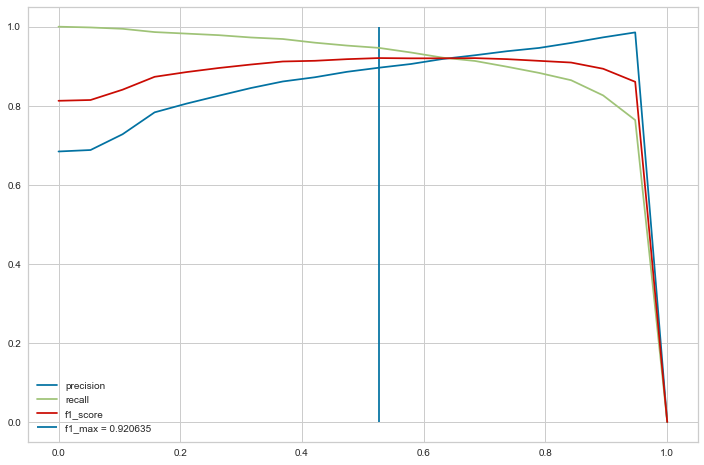

In [92]:
thresholds_range = np.linspace(0,1,20)
precision = [ tf.keras.metrics.Precision(thresholds = k)(y_true, y_pred) for k in thresholds_range]
recall = [ tf.keras.metrics.Recall(thresholds = k)(y_true, y_pred) for k in thresholds_range]
f1 = [ F1_Score(thresholds = k)(y_true, y_pred) for k in thresholds_range]
plt.plot(thresholds_range, precision, label ='precision')
plt.plot(thresholds_range, recall, label ='recall')
plt.plot(thresholds_range, f1, label ='f1_score')
plt.vlines(x = thresholds_range[np.argmax(f1)], ymin = 0, ymax = 1,  label = 'f1_max = {:2f}'.format(np.max(f1)))
plt.legend()
plt.show()

In [80]:
np.argmax(precision)

18